In [239]:
import pyarrow.parquet as pq
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import joblib
import gc

# 1) 회원정보 파일 경로 리스트
member_paths = [
    "open/train/1.회원정보/201807_train_회원정보.parquet",
    "open/train/1.회원정보/201808_train_회원정보.parquet",
    "open/train/1.회원정보/201809_train_회원정보.parquet",
    "open/train/1.회원정보/201810_train_회원정보.parquet",
    "open/train/1.회원정보/201811_train_회원정보.parquet",
    "open/train/1.회원정보/201812_train_회원정보.parquet",
]

# 2) 회원정보 통합 및 세그먼트 인코딩
df_members = pd.concat([pd.read_parquet(p)[['ID', 'Segment']] for p in member_paths])
le = LabelEncoder()
df_members['Segment_code'] = le.fit_transform(df_members['Segment'])

# 3) 분석에 사용할 파일과 컬럼
file_columns = {
    "open/train/1.회원정보/201807_train_회원정보.parquet": [
        'ID', '이용금액_R3M_신용체크', '이용금액_R3M_신용', '_1순위카드이용금액'
    ],
    "open/train/1.회원정보/201808_train_회원정보.parquet": [
        'ID', '이용금액_R3M_신용체크', '이용금액_R3M_신용', '_1순위카드이용금액'
    ],
    "open/train/1.회원정보/201809_train_회원정보.parquet": [
        'ID', '이용금액_R3M_신용체크', '이용금액_R3M_신용', '_1순위카드이용금액'
    ],
    "open/train/1.회원정보/201810_train_회원정보.parquet": [
        'ID', '이용금액_R3M_신용체크', '이용금액_R3M_신용', '_1순위카드이용금액'
    ],
    "open/train/1.회원정보/201811_train_회원정보.parquet": [
        'ID', '이용금액_R3M_신용체크', '이용금액_R3M_신용', '_1순위카드이용금액'
    ],
    "open/train/1.회원정보/201812_train_회원정보.parquet": [
        'ID', '이용금액_R3M_신용체크', '이용금액_R3M_신용', '_1순위카드이용금액'
    ],
    "open/train/3.승인매출정보/201807_train_승인매출정보.parquet": [
        'ID', '정상청구원금_B0M', '이용금액_일시불_B0M', '이용금액_오프라인_B0M',
        '정상입금원금_B0M', '정상입금원금_B2M', '최대이용금액_일시불_R12M', '이용건수_일시불_B0M'
    ],
    "open/train/3.승인매출정보/201808_train_승인매출정보.parquet": [
        'ID', '정상청구원금_B0M', '이용금액_일시불_B0M', '이용금액_오프라인_B0M',
        '정상입금원금_B0M', '정상입금원금_B2M', '최대이용금액_일시불_R12M', '이용건수_일시불_B0M'
    ],
    "open/train/3.승인매출정보/201809_train_승인매출정보.parquet": [
        'ID', '정상청구원금_B0M', '이용금액_일시불_B0M', '이용금액_오프라인_B0M',
        '정상입금원금_B0M', '정상입금원금_B2M', '최대이용금액_일시불_R12M', '이용건수_일시불_B0M'
    ],
    "open/train/3.승인매출정보/201810_train_승인매출정보.parquet": [
        'ID', '정상청구원금_B0M', '이용금액_일시불_B0M', '이용금액_오프라인_B0M',
        '정상입금원금_B0M', '정상입금원금_B2M', '최대이용금액_일시불_R12M', '이용건수_일시불_B0M'
    ],
    "open/train/3.승인매출정보/201811_train_승인매출정보.parquet": [
        'ID', '정상청구원금_B0M', '이용금액_일시불_B0M', '이용금액_오프라인_B0M',
        '정상입금원금_B0M', '정상입금원금_B2M', '최대이용금액_일시불_R12M', '이용건수_일시불_B0M'
    ],
    "open/train/3.승인매출정보/201812_train_승인매출정보.parquet": [
        'ID', '정상청구원금_B0M', '이용금액_일시불_B0M', '이용금액_오프라인_B0M',
        '정상입금원금_B0M', '정상입금원금_B2M', '최대이용금액_일시불_R12M', '이용건수_일시불_B0M'
    ],
    "open/train/4.청구입금정보/201812_train_청구정보.parquet": [
        'ID', '청구금액_R6M'
    ],
    "open/train/5.잔액정보/201812_train_잔액정보.parquet": [
        'ID', '평잔_일시불_6M', '월중평잔_일시불_B0M', '잔액_할부_B0M'
    ]
}

# 4) 데이터 병합
data_chunks = []
for path, cols in file_columns.items():
    df = pd.read_parquet(path, columns=cols)
    if data_chunks:
        existing_cols = set().union(*[set(d.columns) for d in data_chunks])
        overlap = [col for col in df.columns if col in existing_cols and col != 'ID']
        df = df.drop(columns=overlap)
    data_chunks.append(df)

data_merged = data_chunks[0]
for df in data_chunks[1:]:
    data_merged = pd.merge(data_merged, df, on='ID', how='inner')

# 5) 파생 변수 생성
data_merged['평균_일시불_건당단가'] = data_merged['이용금액_일시불_B0M'] / (data_merged['이용건수_일시불_B0M'] + 1)
data_merged['입금대비청구비율_현월'] = data_merged['정상입금원금_B0M'] / (data_merged['정상청구원금_B0M'] + 1)

# 6) 회원정보 병합
full_df = pd.merge(data_merged, df_members[['ID', 'Segment_code']], on='ID', how='inner')

# 7) 컬럼명 변경
full_df.rename(columns={
    '이용금액_R3M_신용체크': '사용금액_신용체크_3M',
    '이용금액_R3M_신용': '사용금액_신용_3M',
    '_1순위카드이용금액': '최우선카드_사용금액',
    '정상청구원금_B0M': '정상청구원금_현월',
    '이용금액_일시불_B0M': '일시불_사용금액_현월',
    '이용금액_오프라인_B0M': '오프라인_사용금액_현월',
    '정상입금원금_B0M': '정상입금원금_현월',
    '정상입금원금_B2M': '정상입금원금_2개월전',
    '최대이용금액_일시불_R12M': '최대일시불사용금액_12M',
    '이용건수_일시불_B0M': '일시불_이용건수_현월',
    '청구금액_R6M': '청구금액_합계_6M',
    '평잔_일시불_6M': '평균잔액_일시불_6M',
    '월중평잔_일시불_B0M': '월중평잔_일시불_현월',
    '잔액_할부_B0M': '할부잔액_현월',
}, inplace=True)

# 8) 추가 파생변수 (가설 기반)
full_df['카드사용집중도'] = full_df['최우선카드_사용금액'] / (full_df['사용금액_신용_3M'] + 1)
# -> 1순위 카드에 과도하게 집중된 고객은 위험도 또는 세그먼트 영향

full_df['일시불_평균사용금액_대비_최대사용금액비율'] = \
    full_df['평균_일시불_건당단가'] / (full_df['최대일시불사용금액_12M'] + 1)
# -> 최대 일시불 사용 대비 건당 단가 비율로 소비 패턴 변화 감지

full_df['입금변동률'] = \
    (full_df['정상입금원금_현월'] - full_df['정상입금원금_2개월전']) / (full_df['정상입금원금_2개월전'] + 1)
# -> 입금액 증감으로 상환능력 예측 (음수면 입금 감소, 양수면 증가)

full_df['오프라인_비중'] = full_df['오프라인_사용금액_현월'] / (full_df['일시불_사용금액_현월'] + 1)
# -> 오프라인 소비가 많은 고객은 어떤 세그먼트인지 확인

# 9) inf, NaN 처리
full_df.replace([np.inf, -np.inf], np.nan, inplace=True)
full_df.fillna(0, inplace=True)

# 10) 피처/타겟 분리
X = full_df.drop(columns=['ID', 'Segment_code'])
y = full_df['Segment_code']

# 11) 정규화
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 12) 학습/테스트 분리
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# 11) LightGBM 학습
model = lgb.LGBMClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train, feature_name=X.columns.tolist())

# 12) 저장
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(model, 'best_model.pkl')

# 13) 평가
y_pred = model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"\n✅ 전체 테스트 정확도: {acc:.4f}")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.126672 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4937
[LightGBM] [Info] Number of data points in the train set: 1920000, number of used features: 20
[LightGBM] [Info] Start training from score -7.821445
[LightGBM] [Info] Start training from score -9.722904
[LightGBM] [Info] Start training from score -2.935696
[LightGBM] [Info] Start training from score -1.927375
[LightGBM] [Info] Start training from score -0.222000

✅ 전체 테스트 정확도: 0.8566


### 성능 향상을 위한 optuna 튜닝

In [3]:
!pip install optuna

In [253]:
import optuna
import lightgbm as lgb
import numpy as np
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

# 1. 서브 학습/검증셋 나누기
X_subtrain, X_valid, y_subtrain, y_valid = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

# 2. objective 함수 정의 (f1_macro 기준으로 변경)
def objective(trial):
    params = {
        'num_leaves': trial.suggest_int('num_leaves', 20, 64),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.05, 0.15),
        'n_estimators': trial.suggest_int('n_estimators', 50, 150),
        'subsample': trial.suggest_float('subsample', 0.8, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.8, 1.0),
        'random_state': 42,
        'n_jobs': -1
    }

    model = lgb.LGBMClassifier(**params)
    model.fit(X_subtrain, y_subtrain)
    preds = model.predict(X_valid)

    # f1_macro 계산
    f1 = f1_score(y_valid, preds, average='macro')
    return f1

# 3. Optuna 튜닝 (10회만 진행해도 충분)
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

# 4. 최적 파라미터 출력
print("\n✅ Best f1_macro from tuning:", study.best_value)
print("✅ Best Parameters:", study.best_params)

# 5. 최적 파라미터로 전체 학습 및 평가
best_model = lgb.LGBMClassifier(**study.best_params)
best_model.fit(X_train, y_train)

# 예측 및 f1/정확도 출력
y_pred = best_model.predict(X_test)
from sklearn.metrics import classification_report, accuracy_score

print(f"\n🎯 정확도: {accuracy_score(y_test, y_pred):.8f}")
print("\n📊 분류 리포트 (macro 기반 f1-score 포함):")
print(classification_report(y_test, y_pred, digits=4))

[I 2025-07-04 15:37:21,189] A new study created in memory with name: no-name-e82d6ec2-d9ef-42f2-9789-5f2a312e2838


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.113874 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4937
[LightGBM] [Info] Number of data points in the train set: 1536000, number of used features: 20
[LightGBM] [Info] Start training from score -7.821445
[LightGBM] [Info] Start training from score -9.659725
[LightGBM] [Info] Start training from score -2.934213
[LightGBM] [Info] Start training from score -1.928134
[LightGBM] [Info] Start training from score -0.221965
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2025-07-04 15:37:59,156] Trial 0 finished with value: 0.4560727140440267 and parameters: {'num_leaves': 20, 'max_depth': 5, 'learning_rate': 0.09557623255788736, 'n_estimators': 136, 'subsample': 0.9537850602279765, 'colsample_bytree': 0.8569654190250993}. Best is trial 0 with value: 0.4560727140440267.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.123390 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4937
[LightGBM] [Info] Number of data points in the train set: 1536000, number of used features: 20
[LightGBM] [Info] Start training from score -7.821445
[LightGBM] [Info] Start training from score -9.659725
[LightGBM] [Info] Start training from score -2.934213
[LightGBM] [Info] Start training from score -1.928134
[LightGBM] [Info] Start training from score -0.221965
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2025-07-04 15:38:40,229] Trial 1 finished with value: 0.4318001926127426 and parameters: {'num_leaves': 25, 'max_depth': 9, 'learning_rate': 0.11211263360043355, 'n_estimators': 123, 'subsample': 0.8501630073415549, 'colsample_bytree': 0.9787803108593249}. Best is trial 0 with value: 0.4560727140440267.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.117849 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4937
[LightGBM] [Info] Number of data points in the train set: 1536000, number of used features: 20
[LightGBM] [Info] Start training from score -7.821445
[LightGBM] [Info] Start training from score -9.659725
[LightGBM] [Info] Start training from score -2.934213
[LightGBM] [Info] Start training from score -1.928134
[LightGBM] [Info] Start training from score -0.221965
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2025-07-04 15:39:21,362] Trial 2 finished with value: 0.4980057557033132 and parameters: {'num_leaves': 27, 'max_depth': 6, 'learning_rate': 0.09516483021173316, 'n_estimators': 124, 'subsample': 0.8676450579200815, 'colsample_bytree': 0.9658482364717157}. Best is trial 2 with value: 0.4980057557033132.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.124208 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4937
[LightGBM] [Info] Number of data points in the train set: 1536000, number of used features: 20
[LightGBM] [Info] Start training from score -7.821445
[LightGBM] [Info] Start training from score -9.659725
[LightGBM] [Info] Start training from score -2.934213
[LightGBM] [Info] Start training from score -1.928134
[LightGBM] [Info] Start training from score -0.221965
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2025-07-04 15:39:52,904] Trial 3 finished with value: 0.3975662000313701 and parameters: {'num_leaves': 41, 'max_depth': 3, 'learning_rate': 0.10121569968044003, 'n_estimators': 143, 'subsample': 0.8853325931979268, 'colsample_bytree': 0.9268512399999479}. Best is trial 2 with value: 0.4980057557033132.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.117251 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4937
[LightGBM] [Info] Number of data points in the train set: 1536000, number of used features: 20
[LightGBM] [Info] Start training from score -7.821445
[LightGBM] [Info] Start training from score -9.659725
[LightGBM] [Info] Start training from score -2.934213
[LightGBM] [Info] Start training from score -1.928134
[LightGBM] [Info] Start training from score -0.221965
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2025-07-04 15:40:35,408] Trial 4 finished with value: 0.4523625865736921 and parameters: {'num_leaves': 29, 'max_depth': 9, 'learning_rate': 0.10234348452250296, 'n_estimators': 133, 'subsample': 0.8411058185423411, 'colsample_bytree': 0.969403339117824}. Best is trial 2 with value: 0.4980057557033132.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.120520 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4937
[LightGBM] [Info] Number of data points in the train set: 1536000, number of used features: 20
[LightGBM] [Info] Start training from score -7.821445
[LightGBM] [Info] Start training from score -9.659725
[LightGBM] [Info] Start training from score -2.934213
[LightGBM] [Info] Start training from score -1.928134
[LightGBM] [Info] Start training from score -0.221965
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2025-07-04 15:41:22,204] Trial 5 finished with value: 0.49424104237913 and parameters: {'num_leaves': 32, 'max_depth': 7, 'learning_rate': 0.092004839383237, 'n_estimators': 132, 'subsample': 0.993648411020673, 'colsample_bytree': 0.8308125768205578}. Best is trial 2 with value: 0.4980057557033132.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.112333 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4937
[LightGBM] [Info] Number of data points in the train set: 1536000, number of used features: 20
[LightGBM] [Info] Start training from score -7.821445
[LightGBM] [Info] Start training from score -9.659725
[LightGBM] [Info] Start training from score -2.934213
[LightGBM] [Info] Start training from score -1.928134
[LightGBM] [Info] Start training from score -0.221965
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2025-07-04 15:41:54,228] Trial 6 finished with value: 0.4067829600156644 and parameters: {'num_leaves': 49, 'max_depth': 3, 'learning_rate': 0.06643414252657977, 'n_estimators': 149, 'subsample': 0.800198935661372, 'colsample_bytree': 0.8474559431130455}. Best is trial 2 with value: 0.4980057557033132.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.110123 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4937
[LightGBM] [Info] Number of data points in the train set: 1536000, number of used features: 20
[LightGBM] [Info] Start training from score -7.821445
[LightGBM] [Info] Start training from score -9.659725
[LightGBM] [Info] Start training from score -2.934213
[LightGBM] [Info] Start training from score -1.928134
[LightGBM] [Info] Start training from score -0.221965
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2025-07-04 15:43:00,985] Trial 7 finished with value: 0.5429084408490222 and parameters: {'num_leaves': 55, 'max_depth': 10, 'learning_rate': 0.057512704096640915, 'n_estimators': 149, 'subsample': 0.8905460540856406, 'colsample_bytree': 0.9617260594894708}. Best is trial 7 with value: 0.5429084408490222.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.117667 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4937
[LightGBM] [Info] Number of data points in the train set: 1536000, number of used features: 20
[LightGBM] [Info] Start training from score -7.821445
[LightGBM] [Info] Start training from score -9.659725
[LightGBM] [Info] Start training from score -2.934213
[LightGBM] [Info] Start training from score -1.928134
[LightGBM] [Info] Start training from score -0.221965
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2025-07-04 15:43:47,721] Trial 8 finished with value: 0.5064163003372281 and parameters: {'num_leaves': 36, 'max_depth': 8, 'learning_rate': 0.07456509259037415, 'n_estimators': 127, 'subsample': 0.8043686704370481, 'colsample_bytree': 0.9572167822232729}. Best is trial 7 with value: 0.5429084408490222.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.118388 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4937
[LightGBM] [Info] Number of data points in the train set: 1536000, number of used features: 20
[LightGBM] [Info] Start training from score -7.821445
[LightGBM] [Info] Start training from score -9.659725
[LightGBM] [Info] Start training from score -2.934213
[LightGBM] [Info] Start training from score -1.928134
[LightGBM] [Info] Start training from score -0.221965
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2025-07-04 15:44:37,149] Trial 9 finished with value: 0.5067304611168112 and parameters: {'num_leaves': 46, 'max_depth': 8, 'learning_rate': 0.07118535678424258, 'n_estimators': 127, 'subsample': 0.8829102015373188, 'colsample_bytree': 0.8992719782255012}. Best is trial 7 with value: 0.5429084408490222.



✅ Best f1_macro from tuning: 0.5429084408490222
✅ Best Parameters: {'num_leaves': 55, 'max_depth': 10, 'learning_rate': 0.057512704096640915, 'n_estimators': 149, 'subsample': 0.8905460540856406, 'colsample_bytree': 0.9617260594894708}
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.146951 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4937
[LightGBM] [Info] Number of data points in the train set: 1920000, number of used features: 20
[LightGBM] [Info] Start training from score -7.821445
[LightGBM] [Info] Start training from score -9.722904
[LightGBM] [Info] Start training from score -2.935696
[LightGBM] [Info] Start training from score -1.927375
[LightGBM] [Info] Start training from score -0.222000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

In [255]:
# 1) Optuna로 가중치 없이 최적 파라미터 찾기
best_model = lgb.LGBMClassifier(**study.best_params)
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)
print(f"🎯 최적 모델 최종 테스트 정확도 (가중치 없음): {accuracy_score(y_test, y_pred):.4f}")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.174385 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4937
[LightGBM] [Info] Number of data points in the train set: 1920000, number of used features: 20
[LightGBM] [Info] Start training from score -7.821445
[LightGBM] [Info] Start training from score -9.722904
[LightGBM] [Info] Start training from score -2.935696
[LightGBM] [Info] Start training from score -1.927375
[LightGBM] [Info] Start training from score -0.222000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

In [257]:
# 2) 클래스 가중치 계산 (전체 train 데이터 기준)
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

print(np.bincount(y_train))  # train 데이터 클래스 분포 확인
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(zip(np.unique(y_train), class_weights))
print("클래스별 가중치:", class_weights_dict)

[    770     115  101940  279417 1537758]
클래스별 가중치: {0: 498.7012987012987, 1: 3339.1304347826085, 2: 3.766921718658034, 3: 1.374290039618205, 4: 0.24971419430105388}


In [247]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y), y=y)
class_weights_dict = dict(zip(np.unique(y), class_weights))

print("클래스별 가중치:", class_weights_dict)

클래스별 가중치: {0: 493.82716049382714, 1: 3333.3333333333335, 2: 3.7620503174229953, 3: 1.3744051402752246, 4: 0.2497330977517778}


In [259]:
# 3) 가중치 적용하여 최종 모델 재학습 및 평가
best_model_weighted = lgb.LGBMClassifier(**study.best_params, class_weight=class_weights_dict)
best_model_weighted.fit(X_train, y_train)
y_pred_weighted = best_model_weighted.predict(X_test)

from sklearn.metrics import accuracy_score, classification_report
print("🎯 정확도 (가중치 적용):", accuracy_score(y_test, y_pred_weighted))
print("\n📊 세그먼트별 평가 (가중치 적용):\n", classification_report(y_test, y_pred_weighted))

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.154674 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4937
[LightGBM] [Info] Number of data points in the train set: 1920000, number of used features: 20
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
🎯 정확도 (가중치 적용): 0.8079854166666667

📊 세그먼트별 평가 (가중치 적용):
               precision    recall  f1-score   support

           0       0.79      1.00      0.88       202
           1       1.00      1.00      1.00        29
           2       0.48      0.78      0.60     25650
           3       0.45      0.69      0.54     69825
           4       0.97      0.83  

### segment 등급별 학습이 잘 되었는지 확인

- LightGBM 기반 분류 모델을 통해 총 5개의 고객 세그먼트를 약 85.6%의 정확도로 예측하였다. 
- 가장 중요한 변수로는 '이용금액_일시불_R6M', '청구금액_B0', '잔액_할부_B0M' 등이 도출되었으며, 
- 특정 세그먼트 간의 오분류 비율이 높아 향후 데이터 보완 및 피처 엔지니어링 여지가 있다.

In [12]:
!pip install shap

### 학습 시 어느 데이터가 주요하게 사용되었는지 알 수 있다.

In [205]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 윈도우 기본 한글 폰트 경로 예시
font_path = "C:/Windows/Fonts/malgun.ttf"  # 맑은 고딕

font_prop = fm.FontProperties(fname=font_path)
plt.rcParams['font.family'] = font_prop.get_name()


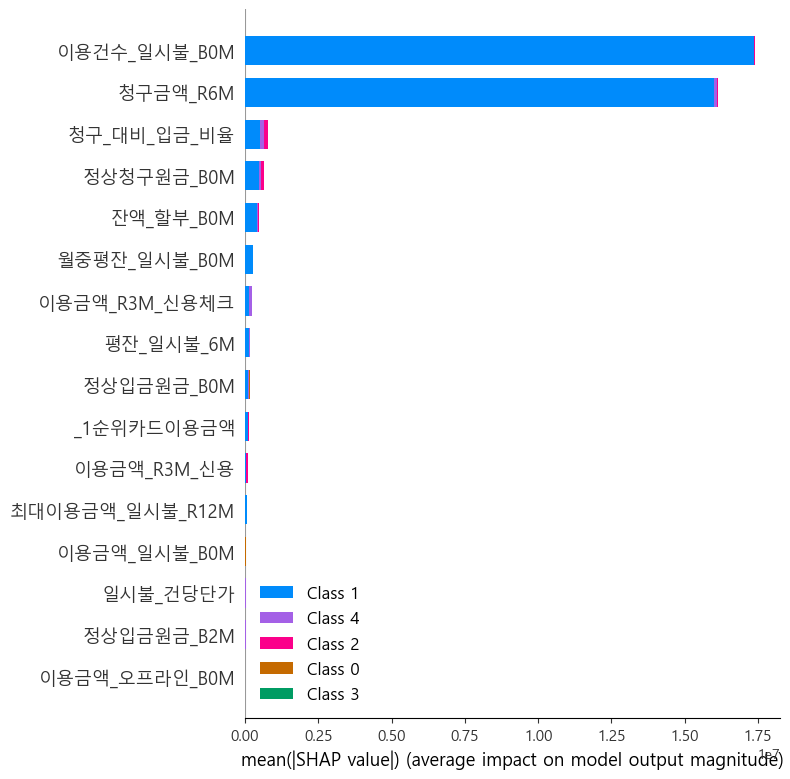

In [207]:
import shap
import pandas as pd

# 2000개 샘플 + 컬럼명 붙이기
X_sample = pd.DataFrame(X_test[:2000], columns=X.columns)

explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_sample)

shap.summary_plot(shap_values, X_sample, plot_type='bar')

### 세그먼트 별 성능 상세 리포트

In [209]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.48      0.51      0.50       202
           1       0.15      0.23      0.18        31
           2       0.63      0.52      0.57     25157
           3       0.57      0.51      0.54     68099
           4       0.91      0.94      0.92    350990

    accuracy                           0.85    444479
   macro avg       0.55      0.54      0.54    444479
weighted avg       0.84      0.85      0.84    444479



### 모델의 안정성 평가

In [211]:
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
import numpy as np

# StratifiedKFold로 클래스 비율 유지하며 3겹 분할
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

acc_scores = []

for fold, (train_idx, val_idx) in enumerate(skf.split(X_scaled, y)):
    print(f"Fold {fold+1} 시작")

    X_train_fold, X_val_fold = X_scaled[train_idx], X_scaled[val_idx]
    y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]

    model = lgb.LGBMClassifier(**study.best_params)  # 튜닝된 파라미터 사용
    model.fit(X_train_fold, y_train_fold)

    y_pred_fold = model.predict(X_val_fold)
    acc = accuracy_score(y_val_fold, y_pred_fold)
    acc_scores.append(acc)

    print(f"Fold {fold+1} 정확도: {acc:.4f}")

print(f"\n전체 평균 정확도: {np.mean(acc_scores):.4f} ± {np.std(acc_scores):.4f}")

Fold 1 시작
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021032 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3916
[LightGBM] [Info] Number of data points in the train set: 1481596, number of used features: 16
[LightGBM] [Info] Start training from score -7.747162
[LightGBM] [Info] Start training from score -9.644282
[LightGBM] [Info] Start training from score -2.871917
[LightGBM] [Info] Start training from score -1.870583
[LightGBM] [Info] Start training from score -0.237142
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

- 오차범위 ± 0.01로 꽤나 안정성 있음

In [213]:
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score
import numpy as np

# StratifiedKFold: 클래스 비율 유지하며 n_splits=3 (조정 가능)
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

acc_scores = []
f1_scores = []

for fold, (train_idx, val_idx) in enumerate(skf.split(X_scaled, y)):
    print(f"Fold {fold+1} 시작")

    X_train_fold, X_val_fold = X_scaled[train_idx], X_scaled[val_idx]
    y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]

    model = lgb.LGBMClassifier(**study.best_params)  # 최적 하이퍼파라미터 적용
    model.fit(X_train_fold, y_train_fold)

    y_pred_fold = model.predict(X_val_fold)

    acc = accuracy_score(y_val_fold, y_pred_fold)
    f1 = f1_score(y_val_fold, y_pred_fold, average='weighted')  # 다중 클래스용 가중평균

    acc_scores.append(acc)
    f1_scores.append(f1)

    print(f"Fold {fold+1} 정확도: {acc:.4f}, F1-score: {f1:.4f}")

print(f"\n전체 평균 정확도: {np.mean(acc_scores):.4f} ± {np.std(acc_scores):.4f}")
print(f"전체 평균 F1-score: {np.mean(f1_scores):.4f} ± {np.std(f1_scores):.4f}")

Fold 1 시작
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020601 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3916
[LightGBM] [Info] Number of data points in the train set: 1481596, number of used features: 16
[LightGBM] [Info] Start training from score -7.747162
[LightGBM] [Info] Start training from score -9.644282
[LightGBM] [Info] Start training from score -2.871917
[LightGBM] [Info] Start training from score -1.870583
[LightGBM] [Info] Start training from score -0.237142
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

In [215]:
import joblib

# 학습 완료된 모델이 model 변수에 있을 때
joblib.dump(model, 'best_model1.pkl')

['best_model1.pkl']

In [229]:
import pandas as pd
import joblib

# 1) 모델 및 스케일러 로드
model = joblib.load('best_model.pkl')
scaler = joblib.load('scaler.pkl')

# 2) 테스트 회원정보 파일 경로
test_member_paths = [
    "open/test/1.회원정보/201807_test_회원정보.parquet",
    "open/test/1.회원정보/201808_test_회원정보.parquet",
    "open/test/1.회원정보/201809_test_회원정보.parquet",
    "open/test/1.회원정보/201810_test_회원정보.parquet",
    "open/test/1.회원정보/201811_test_회원정보.parquet",
    "open/test/1.회원정보/201812_test_회원정보.parquet",
]

# 3) 회원 ID 통합
df_test_members = pd.concat([pd.read_parquet(p)[['ID']] for p in test_member_paths])
df_test_members = df_test_members.drop_duplicates()

# 4) 테스트에 사용할 컬럼 및 파일
file_columns_test = {
   "open/test/1.회원정보/201812_test_회원정보.parquet": [
        'ID', '이용금액_R3M_신용체크', '이용금액_R3M_신용', '_1순위카드이용금액'
    ],
    "open/test/3.승인매출정보/201807_test_승인매출정보.parquet": [
        'ID', '정상청구원금_B0M', '이용금액_일시불_B0M', '이용금액_오프라인_B0M',
        '정상입금원금_B0M', '정상입금원금_B2M', '최대이용금액_일시불_R12M', '이용건수_일시불_B0M'
    ],
    "open/test/4.청구입금정보/201807_test_청구정보.parquet": [
        'ID', '청구금액_R6M'
    ],
    "open/test/5.잔액정보/201807_test_잔액정보.parquet": [
        'ID', '평잔_일시불_6M', '월중평잔_일시불_B0M', '잔액_할부_B0M'
    ]
}

# 5) 데이터 병합
data_chunks_test = []
for path, cols in file_columns_test.items():
    df = pd.read_parquet(path, columns=cols)
    if data_chunks_test:
        existing_cols = set().union(*[set(d.columns) for d in data_chunks_test])
        overlap = [col for col in df.columns if col in existing_cols and col != 'ID']
        df = df.drop(columns=overlap)
    data_chunks_test.append(df)

data_merged_test = data_chunks_test[0]
for df in data_chunks_test[1:]:
    data_merged_test = pd.merge(data_merged_test, df, on='ID', how='inner')

# 6) 회원 ID와 병합
full_test_df = pd.merge(data_merged_test, df_test_members, on='ID', how='inner')

# 7) 파생변수 생성 (학습 때와 동일)
full_test_df['일시불_건당단가'] = full_test_df['이용금액_일시불_B0M'] / (full_test_df['이용건수_일시불_B0M'] + 1)
full_test_df['청구_대비_입금_비율'] = full_test_df['정상입금원금_B0M'] / (full_test_df['정상청구원금_B0M'] + 1)

# 8) 학습 시 사용한 컬럼 리스트 (파생변수 포함, 순서 동일하게)
feature_columns = [
    '이용금액_R3M_신용체크', '이용금액_R3M_신용', '_1순위카드이용금액',
    '정상청구원금_B0M', '이용금액_일시불_B0M', '이용금액_오프라인_B0M',
    '정상입금원금_B0M', '정상입금원금_B2M', '최대이용금액_일시불_R12M', '이용건수_일시불_B0M',
    '청구금액_R6M', '평잔_일시불_6M', '월중평잔_일시불_B0M', '잔액_할부_B0M',
    '일시불_건당단가', '청구_대비_입금_비율'
]

# 9) 누락 컬럼 0으로 채우기 및 결측치 처리
for col in feature_columns:
    if col not in full_test_df.columns:
        full_test_df[col] = 0

# inf, -inf -> NaN 변환
full_test_df[feature_columns] = full_test_df[feature_columns].replace([float('inf'), -float('inf')], pd.NA)

# NaN 채우기 (0 또는 적절한 값)
full_test_df[feature_columns] = full_test_df[feature_columns].fillna(0)

# (선택) 너무 큰 값 클리핑 (예: ±1e10) - 필요 없으면 빼도 됨
max_val = 1e10
full_test_df[feature_columns] = full_test_df[feature_columns].clip(lower=-max_val, upper=max_val)

# 10) 모델 입력 데이터 준비 (컬럼 순서 완벽 일치)
X_test = full_test_df.loc[:, feature_columns]

# 11) 스케일링
X_test_scaled = scaler.transform(X_test)

# 12) 예측
preds = model.predict(X_test_scaled)

# 13) 결과 저장
result = full_test_df[['ID']].copy()
result['prediction'] = preds
result = result.drop_duplicates(subset='ID')

# 14) 숫자 → 알파벳 변환
code_to_alpha = {0:'A', 1:'B', 2:'C', 3:'D', 4:'E'}
result['prediction'] = result['prediction'].map(code_to_alpha)

result.to_csv('test_predictions_alpha1.csv', index=False)
print("✅ 예측 완료 및 저장 → test_predictions_alpha1.csv")

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_29264\2581836932.py:78: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  full_test_df[feature_columns] = full_test_df[feature_columns].fillna(0)


✅ 예측 완료 및 저장 → test_predictions_alpha1.csv


In [231]:
# 회원정보 파일들 다시 불러오기 (train 기준)
member_paths = [
    
    "open/train/1.회원정보/201812_train_회원정보.parquet",
]

import pandas as pd
from sklearn.preprocessing import LabelEncoder
import joblib

# Segment만 불러와서 LabelEncoder 복원
df_members = pd.concat([pd.read_parquet(p)[['Segment']] for p in member_paths])
le = LabelEncoder()
le.fit(df_members['Segment'])

# 저장
joblib.dump(le, 'label_encoder.pkl')

print("✅ LabelEncoder 복원 및 저장 완료")

✅ LabelEncoder 복원 및 저장 완료


C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_29264\1118548340.py:27: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Malgun Gothic.
  plt.tight_layout()
C:\Users\USER\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Malgun Gothic.
  fig.canvas.print_figure(bytes_io, **kw)


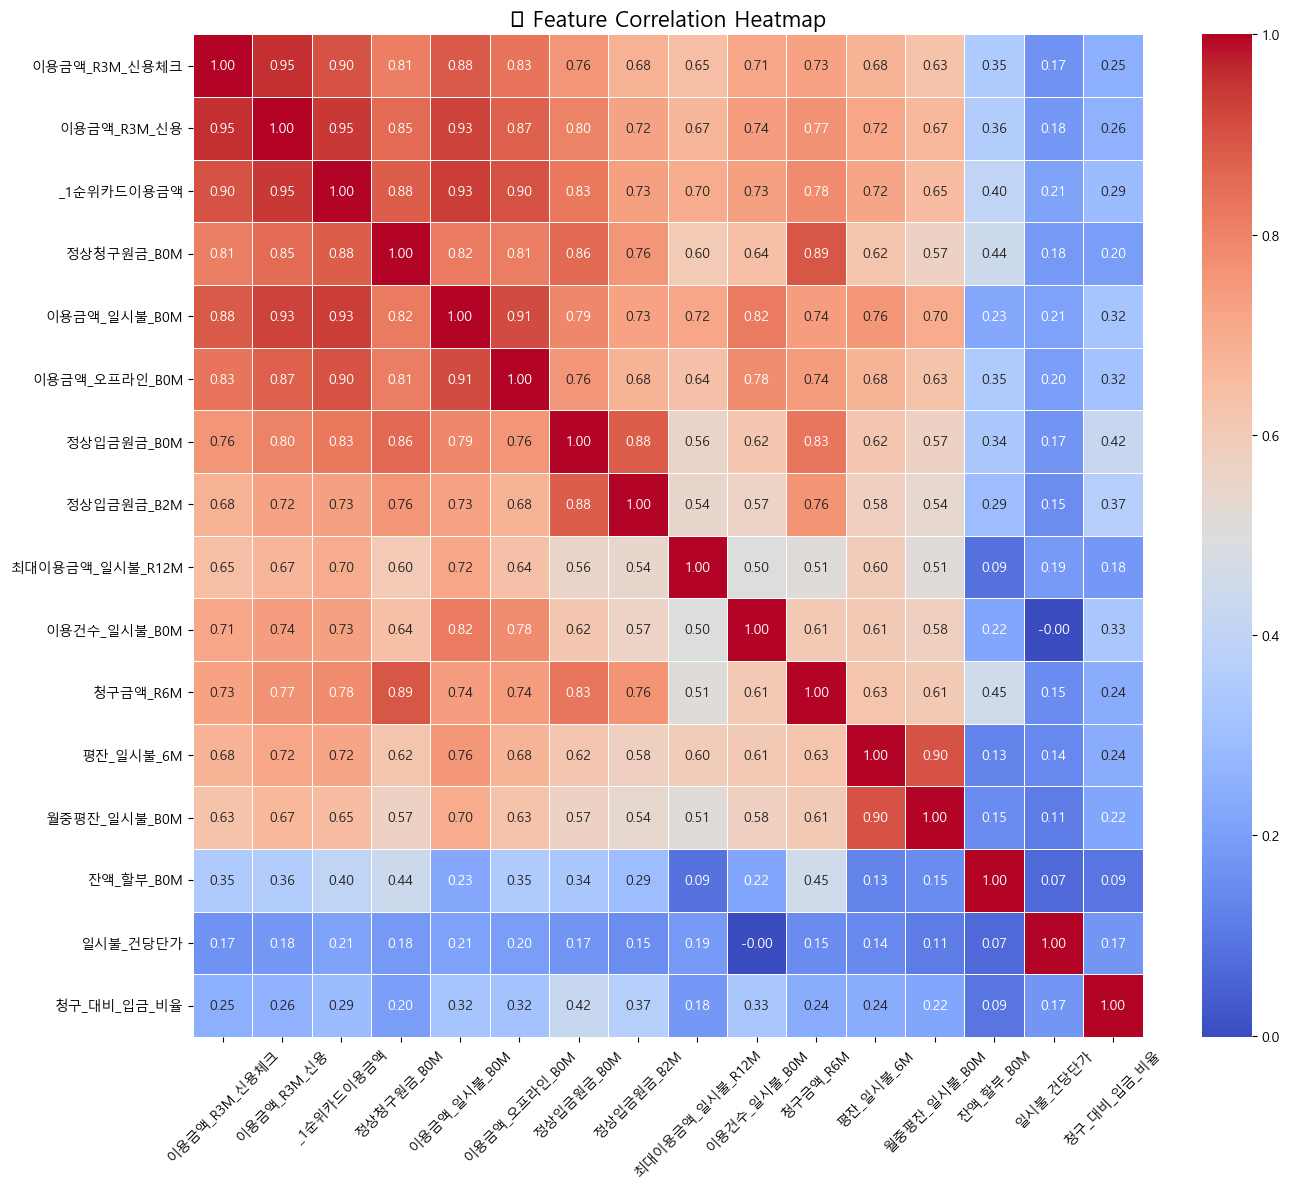

In [233]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. 분석에 사용했던 피처들만 선택
# (full_df는 학습 데이터라고 가정)
selected_columns = [
    '이용금액_R3M_신용체크', '이용금액_R3M_신용', '_1순위카드이용금액',
    '정상청구원금_B0M', '이용금액_일시불_B0M', '이용금액_오프라인_B0M',
    '정상입금원금_B0M', '정상입금원금_B2M', '최대이용금액_일시불_R12M', '이용건수_일시불_B0M',
    '청구금액_R6M', '평잔_일시불_6M', '월중평잔_일시불_B0M', '잔액_할부_B0M',
    '일시불_건당단가', '청구_대비_입금_비율'
]

# 2. 해당 피처들만 추출
df_corr = full_df[selected_columns].copy()

# 3. 상관계수 행렬 계산
corr_matrix = df_corr.corr()

# 4. 히트맵 시각화
plt.figure(figsize=(14, 12))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
plt.title("📊 Feature Correlation Heatmap", fontsize=16)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [237]:
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor
import numpy as np

# 1. full_df에서 피처들만 추출
selected_columns = [
    '이용금액_R3M_신용체크', '이용금액_R3M_신용', '_1순위카드이용금액',
    '정상청구원금_B0M', '이용금액_일시불_B0M', '이용금액_오프라인_B0M',
    '정상입금원금_B0M', '정상입금원금_B2M', '최대이용금액_일시불_R12M', '이용건수_일시불_B0M',
    '청구금액_R6M', '평잔_일시불_6M', '월중평잔_일시불_B0M', '잔액_할부_B0M',
    '일시불_건당단가', '청구_대비_입금_비율'
]

X_vif = full_df[selected_columns].copy()

# 2. inf, -inf를 NaN으로 변환
X_vif.replace([np.inf, -np.inf], np.nan, inplace=True)

# 3. NaN 행 제거
X_vif.dropna(inplace=True)

# 4. VIF 계산
vif_data = pd.DataFrame()
vif_data["feature"] = X_vif.columns
vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]

# 5. 결과 정렬 및 출력
vif_data = vif_data.sort_values(by="VIF", ascending=False)
print(vif_data)

            feature        VIF
4      이용금액_일시불_B0M  35.078454
1       이용금액_R3M_신용  33.473723
2        _1순위카드이용금액  30.993400
0     이용금액_R3M_신용체크  17.729976
3        정상청구원금_B0M  16.090562
6        정상입금원금_B0M  12.589999
5     이용금액_오프라인_B0M  12.561710
10         청구금액_R6M   9.481978
11        평잔_일시불_6M   8.887569
12     월중평잔_일시불_B0M   7.193973
7        정상입금원금_B2M   6.686198
9      이용건수_일시불_B0M   6.271768
8   최대이용금액_일시불_R12M   3.335064
15      청구_대비_입금_비율   2.595406
13        잔액_할부_B0M   2.212230
14         일시불_건당단가   1.557460


In [1]:
import shap
import pandas as pd

# (1) 테스트 데이터 일부 샘플링 (예: 2000개)
X_sample = pd.DataFrame(X_test[:2000], columns=X.columns)

# (2) SHAP 설명기 생성 (LightGBM 등 tree 기반 모델 전용)
explainer = shap.TreeExplainer(best_model)

# (3) SHAP 값 계산
shap_values = explainer.shap_values(X_sample)

# (4) SHAP 점그래프 시각화 (컬러 점들로 영향력과 방향성 표현)
shap.summary_plot(shap_values, X_sample)

NameError: name 'X_test' is not defined

In [35]:
import pandas as pd

# 1. 데이터 읽기
df1 = pd.read_parquet("open/train/4.청구입금정보/201812_train_청구정보.parquet")
df2 = pd.read_parquet("open/train/3.승인매출정보/201812_train_승인매출정보.parquet")
df3 = pd.read_parquet("open/train/5.잔액정보/201812_train_잔액정보.parquet")
df4 = pd.read_parquet("open/train/1.회원정보/201812_train_회원정보.parquet")

# 2. ID 기준으로 병합 (suffix로 중복 컬럼 구분)
merged_df = df1.merge(df2, on='ID', how='inner', suffixes=('_청구', '_승인')) \
               .merge(df3, on='ID', how='inner', suffixes=('', '_잔액'))

# 3. 회원정보 병합 전 중복 컬럼 제거 (기준년월 제외)
df4_drop = df4.drop(columns=['기준년월'])

# 4. 회원정보 병합 (기준년월 컬럼 제외했으니 suffix 안 줘도 됨)
merged_df = merged_df.merge(df4_drop, on='ID', how='inner')

# 5. 컬럼명 확인
print(merged_df.columns)

# 6. 독립변수, 종속변수 설정 (컬럼명은 출력 결과 보고 수정하세요)
X = merged_df[[
    '이용금액_R3M_신용체크', '이용금액_R3M_신용', '_1순위카드이용금액',
    '정상청구원금_B0M', '이용금액_일시불_B0M', '이용금액_할부_B0M',
    '정상입금원금_B0M', '정상입금원금_B2M', '최대이용금액_일시불_R12M',
    '이용건수_일시불_B0M', '평잔_일시불_6M', '월중평잔_일시불_B0M',
    '잔액_할부_B0M','_2순위카드이용금액', '이용금액_오프라인_B0M','청구금액_R6M', '잔액_할부_B0M'
]]
y = merged_df['Segment']

# 7. 스피어만 상관계수 계산
df_corr = X.copy()
df_corr['Segment'] = y

# Segment가 문자형일 경우 숫자형으로 변환
if df_corr['Segment'].dtype == 'object':
    df_corr['Segment'] = df_corr['Segment'].astype('category').cat.codes

# 숫자형 컬럼만 선택
df_numeric = df_corr.select_dtypes(include=['number'])

# 상관계수 계산
spearman_corr = df_numeric.corr(method='spearman')

# 8. 결과 출력
print(spearman_corr['Segment'].sort_values(ascending=False))

Index(['기준년월_청구', 'ID', '대표결제일', '대표결제방법코드', '대표청구지고객주소구분코드', '대표청구서수령지구분코드',
       '청구서수령방법', '청구서발송여부_B0', '청구서발송여부_R3M', '청구서발송여부_R6M',
       ...
       '할인금액_제휴연회비_B0M', '청구금액_기본연회비_B0M', '청구금액_제휴연회비_B0M', '상품관련면제카드수_B0M',
       '임직원면제카드수_B0M', '우수회원면제카드수_B0M', '기타면제카드수_B0M', '카드신청건수', 'Life_Stage',
       '최종카드발급경과월'],
      dtype='object', length=608)
Segment            1.000000
잔액_할부_B0M         -0.217810
잔액_할부_B0M         -0.217810
이용금액_할부_B0M       -0.219851
_2순위카드이용금액        -0.348874
이용건수_일시불_B0M      -0.385579
정상입금원금_B0M        -0.406835
정상입금원금_B2M        -0.409139
평잔_일시불_6M         -0.425189
월중평잔_일시불_B0M      -0.429999
이용금액_일시불_B0M      -0.455815
최대이용금액_일시불_R12M   -0.456054
이용금액_오프라인_B0M     -0.466469
_1순위카드이용금액        -0.469369
이용금액_R3M_신용       -0.473696
청구금액_R6M          -0.491395
정상청구원금_B0M        -0.493431
이용금액_R3M_신용체크     -0.510309
Name: Segment, dtype: float64


In [37]:
import pandas as pd

# 1. 데이터 읽기
df1 = pd.read_parquet("open/train/4.청구입금정보/201812_train_청구정보.parquet")
df2 = pd.read_parquet("open/train/3.승인매출정보/201812_train_승인매출정보.parquet")
df3 = pd.read_parquet("open/train/5.잔액정보/201812_train_잔액정보.parquet")
df4 = pd.read_parquet("open/train/1.회원정보/201812_train_회원정보.parquet")

# 2. ID 기준으로 병합 (suffix로 중복 컬럼 구분)
merged_df = df1.merge(df2, on='ID', how='inner', suffixes=('_청구', '_승인')) \
               .merge(df3, on='ID', how='inner', suffixes=('', '_잔액'))

# 3. 회원정보 병합 전 중복 컬럼 제거 (기준년월 제외)
df4_drop = df4.drop(columns=['기준년월'])

# 4. 회원정보 병합 (기준년월 컬럼 제외했으니 suffix 안 줘도 됨)
merged_df = merged_df.merge(df4_drop, on='ID', how='inner')

# 5. 컬럼명 확인
print(merged_df.columns)

# 6. 독립변수, 종속변수 설정 (컬럼명은 출력 결과 보고 수정하세요)
X = merged_df[[
  '이용금액_R3M_신용체크', '이용금액_R3M_신용', '_1순위카드이용금액',
    '정상청구원금_B0M', '이용금액_일시불_B0M', '이용금액_오프라인_B0M',
    '정상입금원금_B0M', '정상입금원금_B2M', '최대이용금액_일시불_R12M', '이용건수_일시불_B0M',
    '청구금액_R6M', '평잔_일시불_6M', '월중평잔_일시불_B0M', '잔액_할부_B0M',
]]
y = merged_df['Segment']

# 7. 스피어만 상관계수 계산
df_corr = X.copy()
df_corr['Segment'] = y

# Segment가 문자형일 경우 숫자형으로 변환
if df_corr['Segment'].dtype == 'object':
    df_corr['Segment'] = df_corr['Segment'].astype('category').cat.codes

# 숫자형 컬럼만 선택
df_numeric = df_corr.select_dtypes(include=['number'])

# 상관계수 계산
spearman_corr = df_numeric.corr(method='spearman')

# 8. 결과 출력
print(spearman_corr['Segment'].sort_values(ascending=False))

Index(['기준년월_청구', 'ID', '대표결제일', '대표결제방법코드', '대표청구지고객주소구분코드', '대표청구서수령지구분코드',
       '청구서수령방법', '청구서발송여부_B0', '청구서발송여부_R3M', '청구서발송여부_R6M',
       ...
       '할인금액_제휴연회비_B0M', '청구금액_기본연회비_B0M', '청구금액_제휴연회비_B0M', '상품관련면제카드수_B0M',
       '임직원면제카드수_B0M', '우수회원면제카드수_B0M', '기타면제카드수_B0M', '카드신청건수', 'Life_Stage',
       '최종카드발급경과월'],
      dtype='object', length=608)
Segment            1.000000
잔액_할부_B0M         -0.217810
이용건수_일시불_B0M      -0.385579
정상입금원금_B0M        -0.406835
정상입금원금_B2M        -0.409139
평잔_일시불_6M         -0.425189
월중평잔_일시불_B0M      -0.429999
이용금액_일시불_B0M      -0.455815
최대이용금액_일시불_R12M   -0.456054
이용금액_오프라인_B0M     -0.466469
_1순위카드이용금액        -0.469369
이용금액_R3M_신용       -0.473696
청구금액_R6M          -0.491395
정상청구원금_B0M        -0.493431
이용금액_R3M_신용체크     -0.510309
Name: Segment, dtype: float64


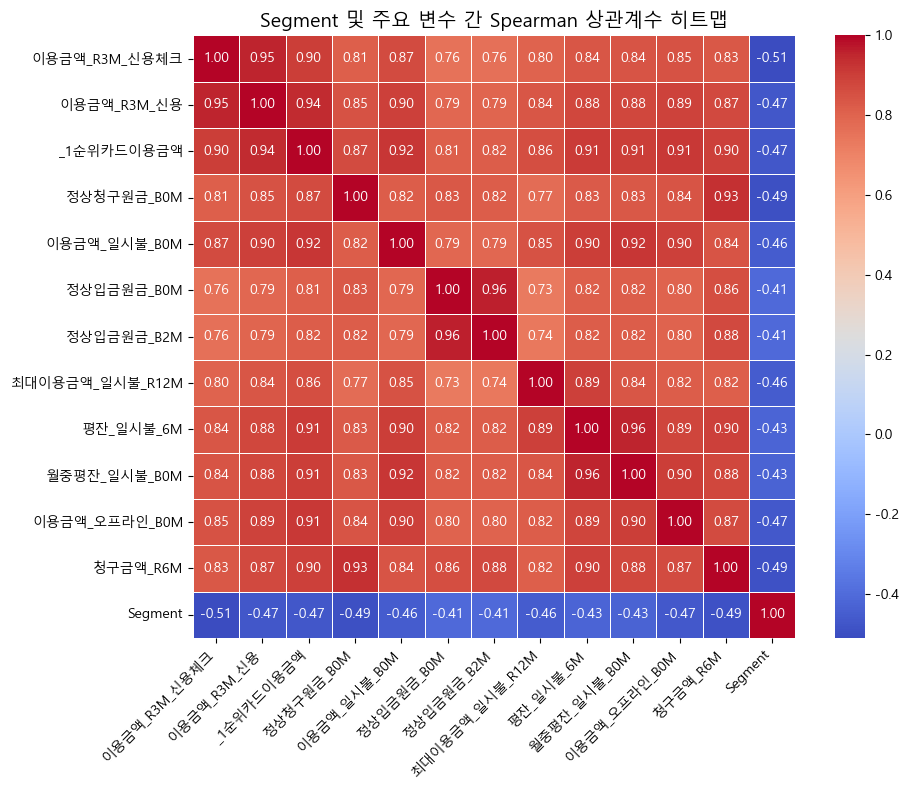

In [43]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib


plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False  # 음수 기호 깨짐 방지

# 1. Segment 범주형이면 숫자로 변환
if merged_df['Segment'].dtype == 'object':
    merged_df['Segment'] = merged_df['Segment'].astype('category').cat.codes

# 2. 상관계수 분석 대상 컬럼 리스트
candidate_features = [
    '이용금액_R3M_신용체크', '이용금액_R3M_신용', '_1순위카드이용금액',
    '정상청구원금_B0M', '이용금액_일시불_B0M', '이용금액_할부_B0M',
    '정상입금원금_B0M', '정상입금원금_B2M', '최대이용금액_일시불_R12M',
    '이용건수_일시불_B0M', '평잔_일시불_6M', '월중평잔_일시불_B0M',
    '잔액_할부_B0M', '이용금액_오프라인_B0M',
    '청구금액_R6M', '잔액_할부_B0M', 'Segment'
]

# 3. 숫자형 필터링 후 Spearman 상관계수 계산
df_corr = merged_df[candidate_features].copy()
df_numeric = df_corr.select_dtypes(include=['number'])
spearman_corr = df_numeric.corr(method='spearman')

# 4. Segment 기준으로 절대값 상관계수 0.4 이상인 변수만 필터링
strong_corr_cols = spearman_corr['Segment'][abs(spearman_corr['Segment']) > 0.4].index.tolist()

# 5. 히트맵 시각화
plt.figure(figsize=(10, 8))
sns.heatmap(spearman_corr.loc[strong_corr_cols, strong_corr_cols],
            annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5, square=True)
plt.title('Segment 및 주요 변수 간 Spearman 상관계수 히트맵', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [51]:
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor

# 숫자형 데이터 선택 및 복사
numeric_df = merged_df.select_dtypes(include=['number']).copy()

# inf 값 처리
numeric_df.replace([np.inf, -np.inf], np.nan, inplace=True)

# 결측치 제거
numeric_df.dropna(axis=0, inplace=True)

# 분산 0인 컬럼 제거
zero_var_cols = numeric_df.columns[numeric_df.var() == 0]
if len(zero_var_cols) > 0:
    print("분산 0인 컬럼 제거:", list(zero_var_cols))
    numeric_df.drop(columns=zero_var_cols, inplace=True)

# VIF 계산
vif_data = pd.DataFrame()
vif_data['feature'] = numeric_df.columns
vif_data['VIF'] = [variance_inflation_factor(numeric_df.values, i) for i in range(numeric_df.shape[1])]

# VIF 5 이하 필터링 및 출력
vif_below_5 = vif_data[vif_data['VIF'] <= 5]
print(vif_below_5)

분산 0인 컬럼 제거: ['기준년월_청구', '청구서발송여부_B0', '청구서발송여부_R3M', '청구서발송여부_R6M', '포인트_마일리지_건별_B0M', '포인트_마일리지_건별_R3M', '포인트_마일리지_월적립_B0M', '포인트_마일리지_월적립_R3M', '포인트_포인트_월적립_B0M', '포인트_포인트_월적립_R3M', '포인트_잔여포인트_B0M', '마일_적립포인트_R12M', '마일_적립포인트_R3M', '마일_이용포인트_R12M', '마일_이용포인트_R3M', '마일_잔여포인트_B0M', '할인금액_R3M', '할인금액_B0M', '할인금액_청구서_R3M', '할인금액_청구서_B0M', '상환개월수_결제일_R3M', '선결제건수_R6M', '선결제건수_R3M', '연체건수_R3M', '포인트_마일리지_환산_B0M', '혜택수혜금액', '기준년월_승인', '이용건수_할부_B0M', '이용건수_할부_유이자_B0M', '이용건수_할부_무이자_B0M', '이용건수_부분무이자_B0M', '이용건수_CA_B0M', '이용건수_체크_B0M', '이용건수_카드론_B0M', '이용금액_할부_B0M', '이용금액_할부_유이자_B0M', '이용금액_할부_무이자_B0M', '이용금액_부분무이자_B0M', '이용금액_CA_B0M', '이용금액_체크_B0M', '이용금액_카드론_B0M', '이용후경과월_부분무이자', '이용후경과월_체크', '이용후경과월_카드론', '이용건수_부분무이자_R12M', '이용건수_체크_R12M', '이용금액_카드론_R12M', '최대이용금액_체크_R12M', '최대이용금액_카드론_R12M', '이용개월수_체크_R12M', '이용건수_할부_R6M', '이용건수_할부_유이자_R6M', '이용건수_할부_무이자_R6M', '이용건수_부분무이자_R6M', '이용건수_CA_R6M', '이용건수_체크_R6M', '이용건수_카드론_R6M', '이용금액_할부_R6M', '이용금액_할부_유이자_R6M', '이용금액_할부_무이자_R6M', '이용금액_부분무이자_

C:\Users\USER\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Empty DataFrame
Columns: [feature, VIF]
Index: []


In [55]:
print(numeric_df.nunique())
print(numeric_df.isna().sum())
print(numeric_df.iloc[:, :5].head(10))

대표결제일                 2
청구금액_B0               3
청구금액_R3M              3
청구금액_R6M              3
포인트_포인트_건별_B0M        2
                     ..
이용여부_3M_해외겸용_본인       2
보유여부_해외겸용_신용_본인       2
이용가능여부_해외겸용_신용_본인     2
이용여부_3M_해외겸용_신용_본인    2
최종카드발급경과월             3
Length: 225, dtype: int64
대표결제일                 0
청구금액_B0               0
청구금액_R3M              0
청구금액_R6M              0
포인트_포인트_건별_B0M        0
                     ..
이용여부_3M_해외겸용_본인       0
보유여부_해외겸용_신용_본인       0
이용가능여부_해외겸용_신용_본인     0
이용여부_3M_해외겸용_신용_본인    0
최종카드발급경과월             0
Length: 225, dtype: int64
        대표결제일  청구금액_B0  청구금액_R3M  청구금액_R6M  포인트_포인트_건별_B0M
31935      25     4988     16997     40574            4058
134879     23      419      1318      2266               0
154605     23    10214     44804    114562               0


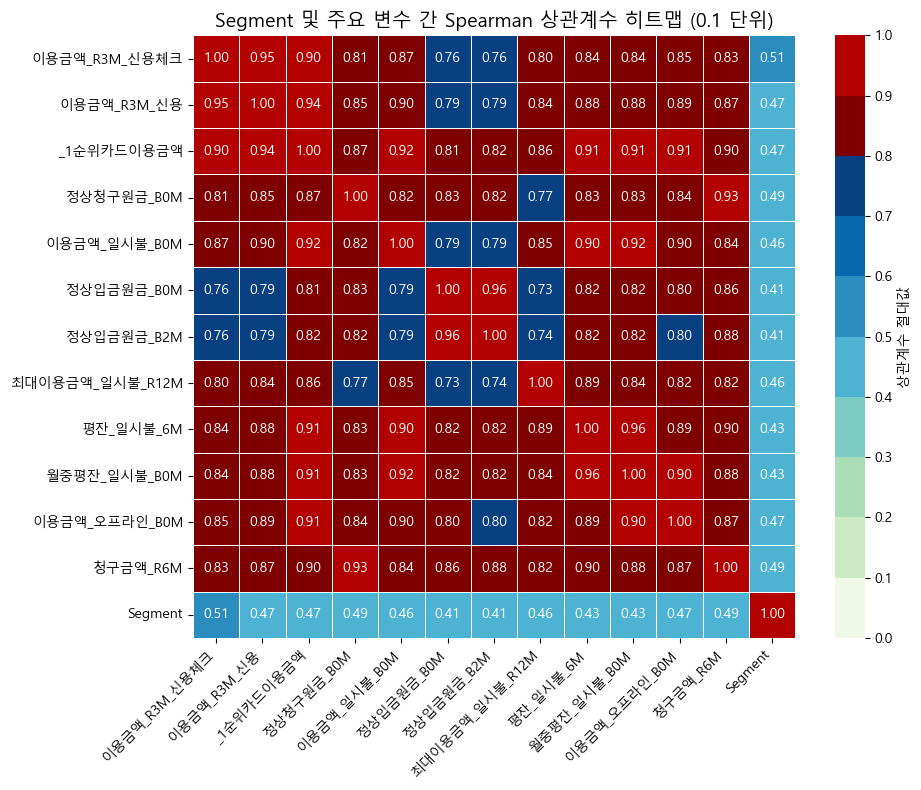

In [69]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm

# Segment 변환
if merged_df['Segment'].dtype == 'object':
    merged_df['Segment'] = merged_df['Segment'].astype('category').cat.codes

# 후보 변수
candidate_features = [
    '이용금액_R3M_신용체크', '이용금액_R3M_신용', '_1순위카드이용금액',
    '정상청구원금_B0M', '이용금액_일시불_B0M', '이용금액_할부_B0M',
    '정상입금원금_B0M', '정상입금원금_B2M', '최대이용금액_일시불_R12M',
    '이용건수_일시불_B0M', '평잔_일시불_6M', '월중평잔_일시불_B0M',
    '잔액_할부_B0M', '이용금액_오프라인_B0M', '청구금액_R6M', 'Segment'
]

# 상관계수 계산
df_corr = merged_df[candidate_features].copy()
df_corr = df_corr.select_dtypes(include=['number'])
spearman_corr = df_corr.corr(method='spearman')

# 절대값 상관계수 0.4 이상만 필터링
strong_corr_cols = spearman_corr.loc[abs(spearman_corr['Segment']) > 0.4].index.tolist()

# 색상 범위 및 컬러맵 (0.1 간격)
bounds = [i / 10 for i in range(11)]  # [0.0, 0.1, ..., 1.0]
colors = [
    '#f0f9e8', '#ccebc5', '#a8ddb5', '#7bccc4', '#4eb3d3',
    '#2b8cbe', '#0868ac', '#084081', '#7f0000', '#b30000'
]
cmap = ListedColormap(colors)
norm = BoundaryNorm(bounds, cmap.N)

# 히트맵 그리기
plt.figure(figsize=(10, 8))
sns.heatmap(
    spearman_corr.loc[strong_corr_cols, strong_corr_cols].abs(),
    cmap=cmap,
    norm=norm,
    annot=True,
    fmt=".2f",
    square=True,
    linewidths=0.5,
    cbar_kws={'ticks': bounds, 'label': '상관계수 절대값'}
)
plt.title('Segment 및 주요 변수 간 Spearman 상관계수 히트맵 (0.1 단위)', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()